## Preprosessing

### Create File CSV

In [172]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from textblob import Word
from matplotlib import pyplot
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [173]:
data_folder = "Dataset/txt"
folders = ["campuran","maju","mundur"]

os.chdir(data_folder)
print(os.getcwd())

/home/antoko/Documents/KULIAH/Semester 6/Kuliah/Penggalian Data/Tugas/Tubes/Coding/Cerpen/Dataset/txt


In [174]:
x, y = ([],[])
for i in folders:
    files = os.listdir(i)
    print(i)
    for text_file in files:
        file_path = i + "/" +text_file
        #         print("reading file:", file_path)
        with open(file_path, encoding='mac_roman') as f:
            data = f.readlines()
        data = ' '.join(data)
        x.append(data)
        y.append(i)

campuran
maju
mundur


In [175]:
# Change to Base Dir
os.chdir('../../')
print(os.getcwd())

/home/antoko/Documents/KULIAH/Semester 6/Kuliah/Penggalian Data/Tugas/Tubes/Coding/Cerpen


In [176]:
check = os.path.exists('dataset.csv')
if check == True:
    print('Dataset Sudah Ada')
    df = pd.read_csv('dataset.csv')
    print(df.head())
else:
    data = {'news': x, 'type': y}
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    print(df.head())

Dataset Sudah Ada
                                                news      type
0  ‚ÄúKumohon. Beri aku waktu lebih lama.‚Äù\n ‚Ä...  campuran
1  Dila dan Rafa adalah sepasang kekasih yang jat...      maju
2  Aku adalah seorang gadis yang sebentar lagi ak...  campuran
3  Hari demi hari tahun telah berganti, rasanya b...    mundur
4  Di antara banyak kenangan yang sudah aku lalui...  campuran


In [177]:
if check == True:
    print('Dataset Sudah Ada')
else:
    print(os.getcwd())
    df.to_csv('dataset.csv', index=False)
    print('writing csv flie ...')

Dataset Sudah Ada


### Cleaning Data

In [178]:
def clean_str(string):
    
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [179]:
data = pd.read_csv('dataset.csv')
# data['type'] = lb_make.fit_transform(data['type'])
x = data['news'].tolist()
y = data['type'].tolist()

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [180]:
for index,value in enumerate(x):
    print(index, end = ' ')
#     x[index] = stemmer.stem(value)
    x[index] = ' '.join([Word(word).lemmatize() for word in clean_str(value).split()])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 

In [181]:
VSM = CountVectorizer().fit_transform(x)
X = TfidfTransformer().fit_transform(VSM)
Y = np.array(y)

### K Fold With BaggingClassifier

In [277]:
# KFOLD
n = 21
from sklearn.model_selection import KFold
kf=KFold(n_splits=n, shuffle=False, random_state=10)
print(kf)  #buat tau Kfold dan parameter defaultnya
i=1        #ini gapenting, cuma buat nandain fold nya.

clf = GaussianNB()

accuracy_model = []
higherAcc = 0
Iterasi = 0
X_train, y_train, X_test, y_test = (0,0,0,0)
for train_index, test_index in kf.split(X):
    print(i, end=' ')
    #     print("TRAIN :", train_index, "TEST :", test_index)
    X_train_temp=X[train_index]
    X_test_temp=X[test_index]
    y_train_temp=Y[train_index]
    y_test_temp=Y[test_index]
    
    # Train the model
    model = clf.fit(X_train_temp.toarray(), y_train_temp)
    # Append to accuracy_model the accuracy of the model
    acc = accuracy_score(y_test_temp, model.predict(X_test_temp.toarray()), normalize=True)*100
    if acc > higherAcc:
        higherAcc = acc
        Iterasi = i
        X_train, y_train, X_test, y_test = (X_train_temp,y_train_temp,X_test_temp,y_test_temp)
    accuracy_model.append(acc)
    i+=1
    
print("shape x_train :", X_train.shape)
print("shape x_test :", X_test.shape)
# Print the accuracy    
print('accuracy : ', accuracy_model)
print(y_test)

scores = pd.DataFrame(accuracy_model,columns=['Scores'])

KFold(n_splits=21, random_state=10, shuffle=False)
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 shape x_train : (201, 15400)
shape x_test : (10, 15400)
accuracy :  [27.27272727272727, 20.0, 30.0, 40.0, 10.0, 20.0, 20.0, 50.0, 30.0, 70.0, 40.0, 50.0, 20.0, 50.0, 30.0, 10.0, 30.0, 0.0, 30.0, 30.0, 40.0]
['mundur' 'maju' 'campuran' 'campuran' 'maju' 'mundur' 'campuran'
 'campuran' 'mundur' 'campuran']


In [28]:
# from sklearn import model_selection
# kfold = model_selection.KFold(n_splits=10)
# mod = GaussianNB()
# res = model_selection.cross_val_score(mod, X.toarray(), y, cv=kfold)
# round(res.mean() * 100, 5)

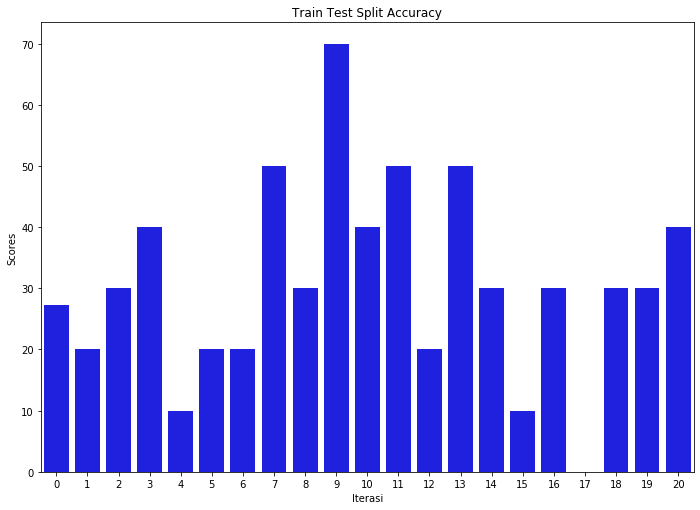

Higher Acc :  70.0% Iterasi Ke : 10


In [278]:
fig, ax = pyplot.subplots(figsize=(11.7, 8.27))

# sns.set(style="white", rc={"lines.linewidth": 3})
sns_plot = sns.barplot(ax=ax, x=list(range(0,n)),y="Scores", data=scores, color="b")
sns_plot.set_title('Train Test Split Accuracy')
sns_plot.figure.savefig("Plot BaggingClassifier Decision Tree.png")
sns_plot.set(xlabel="Iterasi")
plt.show()
print("Higher Acc : ", str(higherAcc)+"%" + " Iterasi Ke : "+str(Iterasi))

### Create Model

### Naive Bayes

In [279]:
clf = GaussianNB()
clf.fit(X_train.toarray(), y_train)

y_pred = clf.predict(X_test.toarray())
c_mat = confusion_matrix(y_test,y_pred)
acc = accuracy_score(y_test,y_pred) * 100
print("Confusion Matrix:\n", c_mat)
print("\nAccuracy: ",str(acc)+"%")

print (classification_report(y_test, y_pred))

Confusion Matrix:
 [[4 1 0]
 [0 2 0]
 [1 1 1]]

Accuracy:  70.0%
              precision    recall  f1-score   support

    campuran       0.80      0.80      0.80         5
        maju       0.50      1.00      0.67         2
      mundur       1.00      0.33      0.50         3

    accuracy                           0.70        10
   macro avg       0.77      0.71      0.66        10
weighted avg       0.80      0.70      0.68        10



### KNN

In [280]:
k_range = range(1,31)  #1-30
k_score = []
highScore = 0
getIterasi = 0
for k in k_range:
    print(k, end=' ')
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train.toarray(), y_train)

    #Predict the response for test dataset
    y_pred = knn.predict(X_test.toarray())
    c_mat = confusion_matrix(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred) * 100
    k_score.append(acc)
    if acc > highScore:
        highScore = acc
        getIterasi = k
print('\n')
print()
print("\nAccuracy: ", k_score)
print("High Score: ", str(highScore) + " (Iterasi " + str(getIterasi) + ")")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 



Accuracy:  [10.0, 60.0, 60.0, 60.0, 90.0, 50.0, 50.0, 50.0, 60.0, 70.0, 80.0, 60.0, 40.0, 40.0, 60.0, 50.0, 50.0, 40.0, 40.0, 40.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 40.0, 30.0, 20.0]
High Score:  90.0 (Iterasi 5)


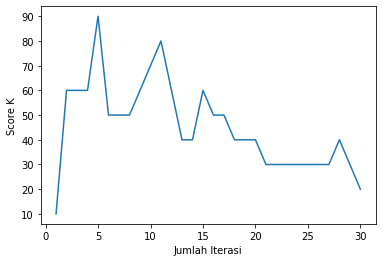

In [281]:
plt.plot(k_range, k_score)
plt.xlabel('Jumlah Iterasi')
plt.ylabel('Score K')
plt.show()

In [282]:
knn = KNeighborsClassifier(n_neighbors=getIterasi, metric='cosine')
knn.fit(X_train.toarray(), y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test.toarray())
c_mat = confusion_matrix(y_test,y_pred)
acc = accuracy_score(y_test,y_pred) * 100
print(acc)
print (classification_report(y_test, y_pred))

90.0
              precision    recall  f1-score   support

    campuran       0.83      1.00      0.91         5
        maju       1.00      1.00      1.00         2
      mundur       1.00      0.67      0.80         3

    accuracy                           0.90        10
   macro avg       0.94      0.89      0.90        10
weighted avg       0.92      0.90      0.89        10

